In [4]:
!pip install rasterio tifffile

In [5]:
import os
import cv2
import torch
import random
import rasterio
import numpy as np

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image


In [6]:
import os
import torch
import rasterio
import numpy as np
import cv2
from PIL import Image
from torch.utils.data import Dataset


class CachedWorldStratDataset(Dataset):

    def __init__(self, root, ratio=0.2, size=128, cache_size=200):

        self.size = size
        self.samples = []
        self.cache = {}
        self.cache_size = cache_size

        hr_root = os.path.join(root, "hr_dataset/12bit")
        lr_root = os.path.join(root, "lr_dataset")


        for scene in os.listdir(hr_root):

            hr_scene = os.path.join(hr_root, scene)
            lr_scene = os.path.join(lr_root, scene, "L2A")

            if not os.path.exists(lr_scene):
                continue


            hr_files = [f for f in os.listdir(hr_scene) if f.endswith("_rgb.png")]

            if len(hr_files) == 0:
                continue

            hr_path = os.path.join(hr_scene, hr_files[0])


            for f in os.listdir(lr_scene):

                if f.endswith("L2A_data.tiff"):

                    lr_path = os.path.join(lr_scene, f)

                    self.samples.append((lr_path, hr_path))


        # Use subset
        self.samples = self.samples[:int(len(self.samples)*ratio)]


        print("Samples:", len(self.samples))


    def load_lr(self, path):

        if path in self.cache:
            return self.cache[path]


        with rasterio.open(path) as src:
            img = src.read()[:3]

        img = np.transpose(img, (1,2,0))

        img = img.astype(np.float32)

        img = img / (img.max()+1e-8)


        img = cv2.resize(img, (self.size, self.size))


        if len(self.cache) < self.cache_size:
            self.cache[path] = img


        return img


    def load_hr(self, path):

        img = Image.open(path).convert("RGB")

        img = np.array(img).astype(np.float32)/255.0

        img = cv2.resize(img, (self.size, self.size))

        return img


    def __getitem__(self, idx):

        lr_path, hr_path = self.samples[idx]

        lr = self.load_lr(lr_path)
        hr = self.load_hr(hr_path)


        lr = torch.FloatTensor(lr).permute(2,0,1)
        hr = torch.FloatTensor(hr).permute(2,0,1)


        return lr, hr


    def __len__(self):
        return len(self.samples)


In [7]:
dataset = CachedWorldStratDataset(
    root="/kaggle/input/worldstrat",
    ratio=0.2,
    size=128,
    cache_size=300
)

loader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0
)


Samples: 6284


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [9]:
class ResidualBlock(nn.Module):

    def __init__(self, c):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv2d(c,c,3,1,1),
            nn.BatchNorm2d(c),
            nn.PReLU(),
            nn.Conv2d(c,c,3,1,1),
            nn.BatchNorm2d(c)
        )


    def forward(self,x):
        return x + self.block(x)



class Generator(nn.Module):

    def __init__(self):
        super().__init__()

        self.start = nn.Sequential(
            nn.Conv2d(3,64,9,1,4),
            nn.PReLU()
        )

        self.res = nn.Sequential(
            *[ResidualBlock(64) for _ in range(8)]
        )

        self.mid = nn.Sequential(
            nn.Conv2d(64,64,3,1,1),
            nn.BatchNorm2d(64)
        )

        self.end = nn.Conv2d(64,3,9,1,4)


    def forward(self,x):

        s = self.start(x)
        r = self.res(s)
        m = self.mid(r)

        x = s + m

        return torch.sigmoid(self.end(x))


In [10]:
G = Generator().to(device)

In [11]:
pretrain_epochs = 3

optimizer = torch.optim.Adam(G.parameters(), lr=1e-4)
criterion = nn.MSELoss()

G.train()


for epoch in range(pretrain_epochs):

    total = 0


    for lr, hr in loader:

        lr = lr.to(device)
        hr = hr.to(device)


        sr = G(lr)

        loss = criterion(sr, hr)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        total += loss.item()


    print(
        f"Pretrain {epoch+1}/{pretrain_epochs} | "
        f"MSE: {total/len(loader):.4f}"
    )





Pretrain 1/3 | MSE: 0.0278
Pretrain 2/3 | MSE: 0.0200
Pretrain 3/3 | MSE: 0.0172


In [12]:
torch.save(G.state_dict(), "generator_pretrained.pth")

(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

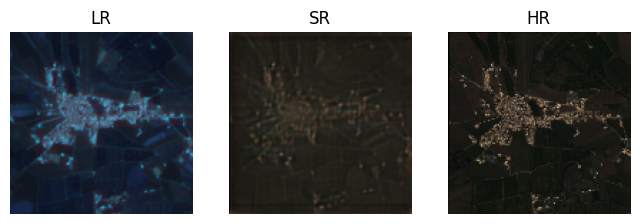

In [13]:
import matplotlib.pyplot as plt

G.eval()

lr, hr = dataset[0]


with torch.no_grad():
    sr = G(lr.unsqueeze(0).to(device))


sr = sr.squeeze().permute(1,2,0).cpu()


plt.figure(figsize=(8,4))

plt.subplot(1,3,1)
plt.title("LR")
plt.imshow(lr.permute(1,2,0))
plt.axis("off")

plt.subplot(1,3,2)
plt.title("SR")
plt.imshow(sr)
plt.axis("off")

plt.subplot(1,3,3)
plt.title("HR")
plt.imshow(hr.permute(1,2,0))
plt.axis("off")


In [14]:
class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()

        def block(in_c, out_c, s):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, s, 1),
                nn.BatchNorm2d(out_c),
                nn.LeakyReLU(0.2)
            )

        self.net = nn.Sequential(
            block(3, 64, 2),
            block(64,128,2),
            block(128,256,2),
            block(256,512,2),

            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512,1024,1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(1024,1,1)
        )


    def forward(self,x):
        return self.net(x).view(-1)


In [15]:
from torchvision.models import vgg19

class VGGFeature(nn.Module):

    def __init__(self):
        super().__init__()

        vgg = vgg19(pretrained=True).features[:35]

        self.vgg = vgg.eval()

        for p in self.vgg.parameters():
            p.requires_grad = False


    def forward(self,x):
        return self.vgg(x)


In [16]:
D = Discriminator().to(device)
VGG = VGGFeature().to(device)

G.load_state_dict(torch.load("generator_pretrained.pth"))

g_opt = torch.optim.Adam(G.parameters(),1e-4,betas=(0.9,0.999))
d_opt = torch.optim.Adam(D.parameters(),1e-4,betas=(0.9,0.999))

bce = nn.BCEWithLogitsLoss()
mse = nn.MSELoss()


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:02<00:00, 194MB/s] 


In [17]:
epochs = 20

G.train()
D.train()
VGG.eval()


def vgg_norm(x):

    mean = torch.tensor([0.485,0.456,0.406]).to(device).view(1,3,1,1)
    std  = torch.tensor([0.229,0.224,0.225]).to(device).view(1,3,1,1)

    return (x-mean)/std


for epoch in range(epochs):

    g_loss_ep = 0
    d_loss_ep = 0


    for lr, hr in loader:

        lr = lr.to(device)
        hr = hr.to(device)

        b = lr.size(0)

        real = torch.ones(b, device=device)
        fake = torch.zeros(b, device=device)


        # Train D
        sr = G(lr).detach()

        d_real = D(hr)
        d_fake = D(sr)

        d_loss = bce(d_real, real) + bce(d_fake, fake)

        d_opt.zero_grad()
        d_loss.backward()
        d_opt.step()


        #Train G
        sr = G(lr)

        adv = bce(D(sr), real)

        cont = mse(sr, hr)

        vgg_loss = mse(
            VGG(vgg_norm(sr)),
            VGG(vgg_norm(hr))
        )


        g_loss = cont + 1e-3*adv + 0.006*vgg_loss


        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()


        g_loss_ep += g_loss.item()
        d_loss_ep += d_loss.item()


    print(
        f"Epoch {epoch+1}/{epochs} | "
        f"G:{g_loss_ep/len(loader):.4f} | "
        f"D:{d_loss_ep/len(loader):.4f}"
    )


Epoch 1/20 | G:0.0389 | D:0.6242
Epoch 2/20 | G:0.0364 | D:0.6470
Epoch 3/20 | G:0.0361 | D:0.5300
Epoch 4/20 | G:0.0357 | D:0.5763
Epoch 5/20 | G:0.0355 | D:0.5295
Epoch 6/20 | G:0.0354 | D:0.6196
Epoch 7/20 | G:0.0357 | D:0.4888
Epoch 8/20 | G:0.0359 | D:0.4443
Epoch 9/20 | G:0.0354 | D:0.5065
Epoch 10/20 | G:0.0348 | D:0.5404
Epoch 11/20 | G:0.0346 | D:0.5515
Epoch 12/20 | G:0.0347 | D:0.5080
Epoch 13/20 | G:0.0345 | D:0.5232
Epoch 14/20 | G:0.0346 | D:0.4163
Epoch 15/20 | G:0.0351 | D:0.3179
Epoch 16/20 | G:0.0352 | D:0.3621
Epoch 17/20 | G:0.0356 | D:0.2587
Epoch 18/20 | G:0.0353 | D:0.2597
Epoch 19/20 | G:0.0354 | D:0.2712
Epoch 20/20 | G:0.0359 | D:0.2354


In [18]:
torch.save(G.state_dict(), "/kaggle/working/G_final.pth")
torch.save(D.state_dict(), "/kaggle/working/D_final.pth")

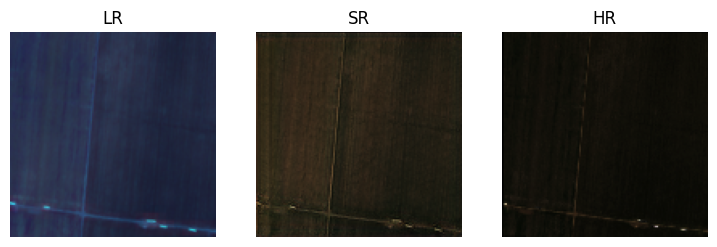

In [20]:
G.eval()

lr, hr = dataset[10]

with torch.no_grad():
    sr = G(lr.unsqueeze(0).to(device))

import matplotlib.pyplot as plt

plt.figure(figsize=(9,3))

for i,(img,title) in enumerate([
    (lr.permute(1,2,0),"LR"),
    (sr.squeeze().permute(1,2,0).cpu(),"SR"),
    (hr.permute(1,2,0),"HR")
]):

    plt.subplot(1,3,i+1)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")

plt.show()


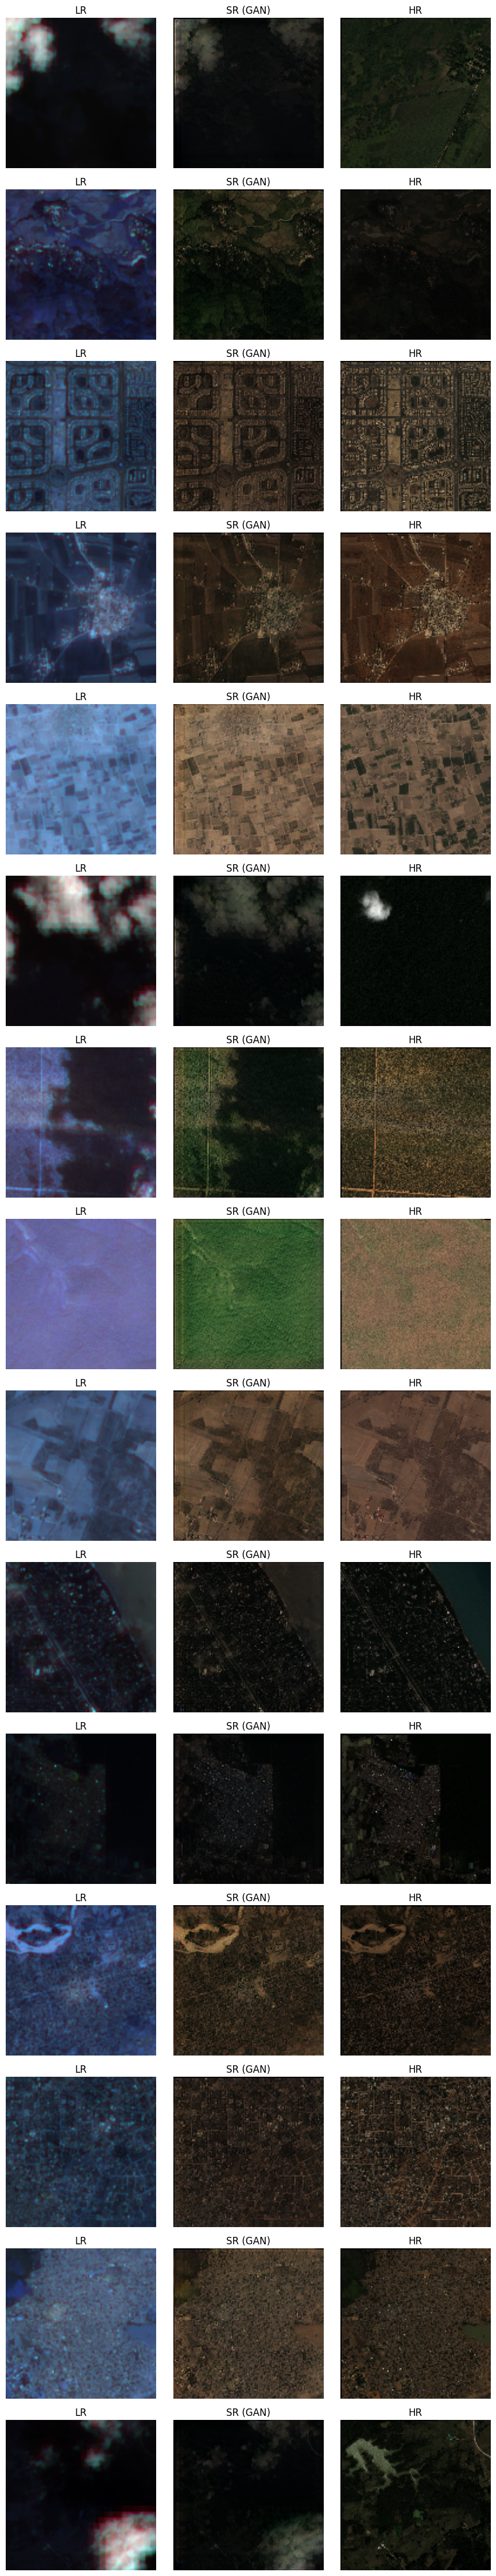

In [33]:
import random
import matplotlib.pyplot as plt

# Putting the model in evaluation mode
G.eval()

NUM_SAMPLES =  15


# Pick random samples
indices = random.sample(range(len(dataset)), NUM_SAMPLES)

plt.figure(figsize=(9, 3*NUM_SAMPLES))


for i, idx in enumerate(indices):

    lr, hr = dataset[idx]

    with torch.no_grad():
        sr = G(lr.unsqueeze(0).to(device))


    sr = sr.squeeze().permute(1,2,0).cpu()


    # Plot
    plt.subplot(NUM_SAMPLES, 3, i*3 + 1)
    plt.imshow(lr.permute(1,2,0))
    plt.title("LR")
    plt.axis("off")


    plt.subplot(NUM_SAMPLES, 3, i*3 + 2)
    plt.imshow(sr)
    plt.title("SR (GAN)")
    plt.axis("off")


    plt.subplot(NUM_SAMPLES, 3, i*3 + 3)
    plt.imshow(hr.permute(1,2,0))
    plt.title("HR")
    plt.axis("off")


plt.tight_layout()
plt.show()


In [22]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import numpy as np

G.eval()

psnr_list = []
ssim_list = []

NUM_TEST = 50   # test on 50 images


for i in range(NUM_TEST):

    lr, hr = dataset[i]

    with torch.no_grad():
        sr = G(lr.unsqueeze(0).to(device))


    sr = sr.squeeze().permute(1,2,0).cpu().numpy()
    hr = hr.permute(1,2,0).numpy()


    psnr = peak_signal_noise_ratio(hr, sr, data_range=1.0)
    ssim = structural_similarity(hr, sr, channel_axis=2, data_range=1.0)

    psnr_list.append(psnr)
    ssim_list.append(ssim)


print("Average PSNR:", np.mean(psnr_list))
print("Average SSIM:", np.mean(ssim_list))


Average PSNR: 23.112892508525547
Average SSIM: 0.5869601


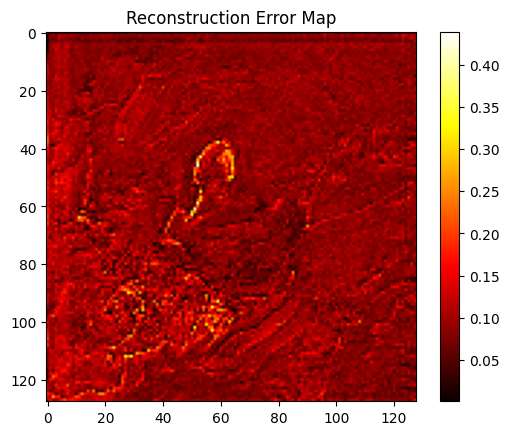

In [25]:
import numpy as np
import matplotlib.pyplot as plt

sr_np = sr
hr_np = hr

# Compute absolute difference
error = np.abs(sr_np - hr_np)

# error map
plt.imshow(error.mean(axis=2), cmap="hot")
plt.colorbar()
plt.title("Reconstruction Error Map")
plt.show()


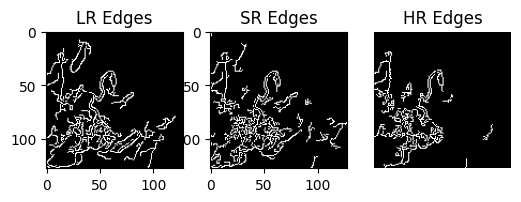

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


lr_img = (lr.permute(1,2,0).cpu().numpy() * 255).astype(np.uint8)

sr_img = (sr * 255).astype(np.uint8)

hr_img = (hr * 255).astype(np.uint8)


# Convert to grayscale
lr_gray = cv2.cvtColor(lr_img, cv2.COLOR_RGB2GRAY)
sr_gray = cv2.cvtColor(sr_img, cv2.COLOR_RGB2GRAY)
hr_gray = cv2.cvtColor(hr_img, cv2.COLOR_RGB2GRAY)


# Canny edges
edges_lr = cv2.Canny(lr_gray, 50, 150)
edges_sr = cv2.Canny(sr_gray, 50, 150)
edges_hr = cv2.Canny(hr_gray, 50, 150)


# Plot
plt.figure(figsize=(6,2))

plt.subplot(1,3,1)
plt.imshow(edges_lr, cmap="gray")
plt.title("LR Edges")

plt.subplot(1,3,2)
plt.imshow(edges_sr, cmap="gray")
plt.title("SR Edges")

plt.subplot(1,3,3)
plt.imshow(edges_hr, cmap="gray")
plt.title("HR Edges")

plt.axis("off")
plt.show()


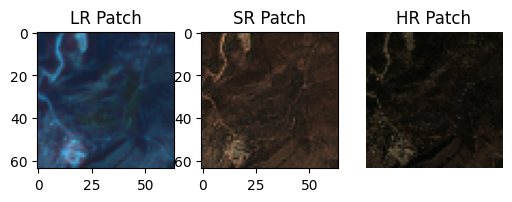

In [32]:
import matplotlib.pyplot as plt
import numpy as np


# Convert all to NumPy (H, W, C)

# LR: Tensor → NumPy
lr_np = lr.permute(1,2,0).cpu().numpy()

sr_np = sr

hr_np = hr


h, w, _ = sr_np.shape


# Select center region
x, y = w//3, h//3
patch = 64


# Crop patches
lr_p = lr_np[y:y+patch, x:x+patch]
sr_p = sr_np[y:y+patch, x:x+patch]
hr_p = hr_np[y:y+patch, x:x+patch]


# Plot
plt.figure(figsize=(6,2))

plt.subplot(1,3,1)
plt.imshow(lr_p)
plt.title("LR Patch")

plt.subplot(1,3,2)
plt.imshow(sr_p)
plt.title("SR Patch")

plt.subplot(1,3,3)
plt.imshow(hr_p)
plt.title("HR Patch")

plt.axis("off")
plt.show()
